In [87]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
! pip install optuna
import optuna

In [88]:
model_name = "bert-base-uncased"

# task 1 , 2 , 3 (load)

In [89]:
with open('bert_vectors_train_'+model_name+'.pkl', 'rb') as f:
    encode_train_vectors, train_labels = pickle.load(f)

with open('bert_vectors_val_'+model_name+'.pkl', 'rb') as f:
    encode_val_vectors, val_labels = pickle.load(f)


In [90]:
print(train_labels.values.shape , encode_train_vectors.shape)
# train_labels = train_labels.values.flatten()
# val_labels  = val_labels.values.flatten()
input_dim_x = encode_train_vectors.shape[1]
print(input_dim_x)

(8480,) (8480, 768)
768


# Task 4

In [91]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        # Convert sparse matrix to dense tensor
        self.x = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(Y.values.flatten(), dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [92]:
train_dataset = CustomDataset(encode_train_vectors, train_labels)
eval_dataset = CustomDataset(encode_val_vectors, val_labels)

In [93]:
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
eval_dataloader = DataLoader(eval_dataset, batch_size = 32, shuffle = False)

In [94]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([32, 768]) torch.Size([32])


## Basic Network

In [95]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [96]:
# if not torch.cuda.is_available():
#     raise RuntimeError("CUDA is not available.")

In [97]:
class DeepNeuralNetworkO(nn.Module):
  def __init__(self, input_dim = 768, output_dim = 2):
    super().__init__()
    self.linear_1 = nn.Linear(input_dim, 256)
    self.activation_1 = nn.ReLU()

    self.linear_2 = nn.Linear(256, 64)
    self.activation_2 = nn.ReLU()

    self.linear_3 = nn.Linear(64, output_dim)

  def forward(self, x):
    out = self.linear_1(x)
    out = self.activation_1(out)

    out = self.linear_2(out)
    out = self.activation_2(out)

    out = self.linear_3(out)

    return out

In [98]:
import torch
network = DeepNeuralNetworkO(input_dim_x).to(device)

In [99]:
from torchsummary import summary
summary(network, (1, input_dim_x))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         196,864
              ReLU-2               [-1, 1, 256]               0
            Linear-3                [-1, 1, 64]          16,448
              ReLU-4                [-1, 1, 64]               0
            Linear-5                 [-1, 1, 2]             130
Total params: 213,442
Trainable params: 213,442
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.81
Estimated Total Size (MB): 0.82
----------------------------------------------------------------


In [100]:
batch_x, batch_y = next(iter(train_dataloader))
print(batch_x.shape, batch_y.shape)

torch.Size([32, 768]) torch.Size([32])


## Basic Training Loop

In [101]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(network.parameters(), lr = 0.001)
epochs = 10

In [102]:
train_epoch_loss = []
eval_epoch_loss = []

In [103]:
for epoch in tqdm(range(epochs)):
    curr_loss = 0
    total = 0
    for train_x, train_y in train_dataloader:

        train_x = train_x.to(device)
        train_y = train_y.to(device)
        optim.zero_grad()

        y_pred = network(train_x)
        loss = criterion(y_pred, train_y)

        loss.backward()
        optim.step()

        curr_loss += loss.item()
        total += len(train_y)
    train_epoch_loss.append(curr_loss / total)

    curr_loss = 0
    total = 0
    for eval_x, eval_y in eval_dataloader:
        eval_x = eval_x.to(device)
        eval_y = eval_y.to(device)
        optim.zero_grad()

        with torch.no_grad():
            y_pred = network(eval_x)

        loss = criterion(y_pred, eval_y)

        curr_loss += loss.item()
        total += len(train_y)
    eval_epoch_loss.append(curr_loss / total)


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


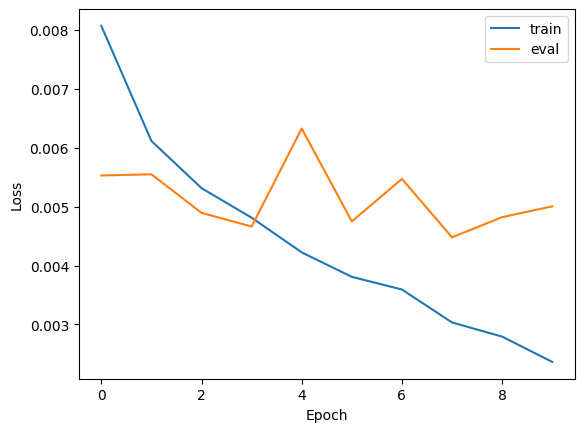

In [104]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_epoch_loss, label='train')
plt.plot(range(epochs), eval_epoch_loss, label='eval')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [105]:
correct = 0
total = 0
for x, y in eval_dataloader:
    x = x.to(device)
    with torch.no_grad():
        yp = network(x)
    yp = torch.argmax(yp.cpu(), dim = 1)
    correct += (yp == y).sum()
    total += len(y)
prev_eval_acc = correct / total
print(f"Accuracy on Eval Data {(prev_eval_acc * 100):.2f}")

Accuracy on Eval Data 94.43


In [106]:
prev_model = network

## now hyperparameter optimization

In [107]:
!pip install torchmetrics
from torchmetrics import Accuracy

In [108]:
import torch.nn.init as init  # Import the init module from PyTorch

class DeepNeuralNetwork2(nn.Module):
    def __init__(self, input_dim, output_dim, n_layers, n_units, dropout_prob, activation, optimizer_name,weight_init_method, learning_rate):
        super(DeepNeuralNetwork2, self).__init__()

        layers = []
        in_features = input_dim
        for i in range(n_layers):
            layers.append(nn.Linear(in_features, n_units))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_prob))
            in_features = n_units
        layers.append(nn.Linear(in_features, output_dim))

        self.layers = nn.Sequential(*layers)
        # Initialize optimizer and learning rate scheduler
        self.optimizer_name = optimizer_name
        self.optimizer = self._get_optimizer(optimizer_name, learning_rate)
        self.apply_weight_init(weight_init_method)
        # self.scheduler = self._get_lr_scheduler(lr_schedule_name)

    def _get_optimizer(self, optimizer_name, learning_rate):
        if optimizer_name == 'Adam':
            return torch.optim.Adam(self.parameters(), lr=learning_rate)
        elif optimizer_name == 'SGD':
            return torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        elif optimizer_name == 'RMSprop':
            return torch.optim.RMSprop(self.parameters(), lr=learning_rate)
        else:
            raise ValueError(f'Invalid optimizer name: {optimizer_name}')

    def apply_weight_init(self, weight_init_method):
        if weight_init_method == 'uniform':
            init_func = init.uniform_
        elif weight_init_method == 'normal':
            init_func = init.normal_
        elif weight_init_method == 'xavier':
            init_func = init.xavier_uniform_
        else:
            raise ValueError(f'Invalid weight initialization method: {weight_init_method}')
        # Apply weight initialization to each linear layer
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init_func(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        return self.layers(x)


In [109]:
def train_model(model, criterion, optimizer, dataloader, device):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Calculate accuracy
        y_pred = torch.argmax(outputs, dim = 1)
        correct_predictions += (y_pred == targets).sum().item()
        total_samples += len(targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    accuracy = correct_predictions / total_samples
    total_loss /= total_samples
    return total_loss, accuracy

In [110]:
def evaluate_model(network, criterion, eval_dataloader, device):
    network.eval()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for eval_x, eval_y in eval_dataloader:
            eval_x = eval_x.to(device)
            eval_y = eval_y.to(device)

            y_pred = network(eval_x)
            loss = criterion(y_pred, eval_y)

            total_loss += loss.item()

            # Calculate accuracy
            y_pred = torch.argmax(y_pred, dim = 1)
            correct_predictions += (y_pred == eval_y).sum().item()
            total_samples += len(eval_y)

    total_loss /= total_samples
    accuracy = correct_predictions / total_samples

    return total_loss, accuracy

In [111]:
import optuna
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.nn.init import xavier_uniform_, kaiming_normal_
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.nn import LeakyReLU, PReLU
from torch.utils.data import DataLoader
from torch.nn import L1Loss, MSELoss

def objective(trial):
    # Define hyperparameters to be optimized
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    n_layers = trial.suggest_int("n_layers", 2, 10)
    n_units = trial.suggest_int("n_units", 16, 512)
    dropout_prob = trial.suggest_float("dropout_prob", 0.0, 0.5)
    activation = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "PReLU"])
    weight_init_method = trial.suggest_categorical("weight_init_method", ["uniform", "normal", "xavier"])
    optimizer_choice = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    # lr_schedule = trial.suggest_categorical("lr_schedule", ["step_lr", "exp_lr"])
    use_early_stopping = trial.suggest_categorical("use_early_stopping", [True, False])
    patience = trial.suggest_int("patience", 5, 20)
    # gradient_accumulation_steps = trial.suggest_int("gradient_accumulation_steps", 1, 5)
    # regularization_strength = trial.suggest_float("regularization_strength", 0.0, 0.1)
    epochs = trial.suggest_int("epochs", 10, 40)

    # Wrap activation functions inside nn.Module subclass
    if activation == "ReLU":
        activation =nn.ReLU()
    elif activation == "LeakyReLU":
        activation =nn.LeakyReLU()
    elif activation == "PReLU":
        activation =nn.PReLU()
    else:
        raise ValueError(f'Invalid activation method: {activation}')

    # Create an instance of your Network
    network = DeepNeuralNetwork2(input_dim=input_dim_x, output_dim=2, n_layers=n_layers,
                            n_units=n_units, dropout_prob=dropout_prob, activation=activation,
                            optimizer_name=optimizer_choice,weight_init_method=weight_init_method, learning_rate = learning_rate)

    optimizer = network.optimizer

    # Move the model to the appropriate device
    network.to(device)
    best_eval_loss = float('inf')
    no_improvement = 0

    # Define DataLoader instances
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    for epoch in tqdm(range(epochs), desc="Epochs"):
        train_loss , train_acc = train_model(network, criterion, optimizer, train_dataloader, device)
        eval_loss, eval_acc = evaluate_model(network, criterion, eval_dataloader, device)

        # Report the validation loss to Optuna for optimization
        trial.report(eval_loss, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Early stopping
        if use_early_stopping:
            if eval_loss < best_eval_loss:
                best_val_loss = eval_loss
                no_improvement = 0
            else:
                no_improvement += 1
                if no_improvement >= patience:
                    break

    print(f"Training acc = {train_acc} , Val acc = {eval_acc}")
    return eval_acc  # eval_loss


In [112]:
# Create Optuna study and run optimization
study = optuna.create_study(direction="maximize")  # or "minimize" for a loss
study.optimize(objective, n_trials=60, timeout=2500)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-13 17:08:03,155] A new study created in memory with name: no-name-7e6c532f-d2ba-4bae-82ef-af8399f9e0f7
Epochs: 100%|██████████| 36/36 [00:50<00:00,  1.41s/it]
[I 2024-03-13 17:08:54,105] Trial 0 finished with value: 0.9349056603773584 and parameters: {'learning_rate': 0.0003316160373203109, 'batch_size': 64, 'n_layers': 9, 'n_units': 112, 'dropout_prob': 0.4167484970960047, 'activation': 'ReLU', 'weight_init_method': 'xavier', 'optimizer': 'Adam', 'use_early_stopping': True, 'patience': 9, 'epochs': 36}. Best is trial 0 with value: 0.9349056603773584.


Training acc = 0.9606132075471698 , Val acc = 0.9349056603773584


Epochs: 100%|██████████| 39/39 [02:20<00:00,  3.60s/it]
[I 2024-03-13 17:11:14,618] Trial 1 finished with value: 0.5 and parameters: {'learning_rate': 0.05253085825626325, 'batch_size': 128, 'n_layers': 5, 'n_units': 370, 'dropout_prob': 0.14957854779736995, 'activation': 'LeakyReLU', 'weight_init_method': 'uniform', 'optimizer': 'RMSprop', 'use_early_stopping': True, 'patience': 10, 'epochs': 39}. Best is trial 0 with value: 0.9349056603773584.


Training acc = 0.5093160377358491 , Val acc = 0.5


Epochs: 100%|██████████| 35/35 [00:14<00:00,  2.50it/s]
[I 2024-03-13 17:11:28,665] Trial 2 finished with value: 0.6018867924528302 and parameters: {'learning_rate': 0.0018940818535772958, 'batch_size': 128, 'n_layers': 10, 'n_units': 41, 'dropout_prob': 0.2746571696315907, 'activation': 'LeakyReLU', 'weight_init_method': 'normal', 'optimizer': 'Adam', 'use_early_stopping': True, 'patience': 16, 'epochs': 35}. Best is trial 0 with value: 0.9349056603773584.


Training acc = 0.485377358490566 , Val acc = 0.6018867924528302


Epochs: 100%|██████████| 25/25 [00:40<00:00,  1.62s/it]
[I 2024-03-13 17:12:09,221] Trial 3 finished with value: 0.95 and parameters: {'learning_rate': 0.00010752574333862809, 'batch_size': 32, 'n_layers': 4, 'n_units': 242, 'dropout_prob': 0.4348817834967466, 'activation': 'ReLU', 'weight_init_method': 'xavier', 'optimizer': 'Adam', 'use_early_stopping': True, 'patience': 16, 'epochs': 25}. Best is trial 3 with value: 0.95.


Training acc = 0.9701650943396226 , Val acc = 0.95


Epochs: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]
[I 2024-03-13 17:12:38,715] Trial 4 finished with value: 0.9235849056603773 and parameters: {'learning_rate': 0.08053467758107107, 'batch_size': 128, 'n_layers': 5, 'n_units': 316, 'dropout_prob': 0.23168141347493726, 'activation': 'LeakyReLU', 'weight_init_method': 'xavier', 'optimizer': 'SGD', 'use_early_stopping': False, 'patience': 14, 'epochs': 30}. Best is trial 3 with value: 0.95.


Training acc = 0.9351415094339622 , Val acc = 0.9235849056603773


Epochs: 100%|██████████| 35/35 [00:20<00:00,  1.70it/s]
[I 2024-03-13 17:12:59,366] Trial 5 finished with value: 0.5 and parameters: {'learning_rate': 0.0002589483708423535, 'batch_size': 64, 'n_layers': 5, 'n_units': 108, 'dropout_prob': 0.18147503890657635, 'activation': 'LeakyReLU', 'weight_init_method': 'uniform', 'optimizer': 'Adam', 'use_early_stopping': False, 'patience': 19, 'epochs': 35}. Best is trial 3 with value: 0.95.


Training acc = 0.5262971698113208 , Val acc = 0.5


Epochs: 100%|██████████| 30/30 [00:28<00:00,  1.06it/s]
[I 2024-03-13 17:13:27,586] Trial 6 finished with value: 0.5 and parameters: {'learning_rate': 0.022745461562932702, 'batch_size': 64, 'n_layers': 6, 'n_units': 152, 'dropout_prob': 0.38019704420997963, 'activation': 'LeakyReLU', 'weight_init_method': 'normal', 'optimizer': 'RMSprop', 'use_early_stopping': False, 'patience': 18, 'epochs': 30}. Best is trial 3 with value: 0.95.


Training acc = 0.5017688679245284 , Val acc = 0.5


Epochs:   0%|          | 0/40 [00:02<?, ?it/s]
[I 2024-03-13 17:13:29,664] Trial 7 pruned. 
Epochs: 100%|██████████| 38/38 [00:52<00:00,  1.38s/it]
[I 2024-03-13 17:14:22,159] Trial 8 finished with value: 0.5 and parameters: {'learning_rate': 0.0010605016425932739, 'batch_size': 64, 'n_layers': 10, 'n_units': 175, 'dropout_prob': 0.4154318721793269, 'activation': 'LeakyReLU', 'weight_init_method': 'uniform', 'optimizer': 'Adam', 'use_early_stopping': False, 'patience': 16, 'epochs': 38}. Best is trial 3 with value: 0.95.


Training acc = 0.5142688679245283 , Val acc = 0.5


Epochs:   0%|          | 0/35 [00:00<?, ?it/s]
[I 2024-03-13 17:14:22,537] Trial 9 pruned. 
Epochs:   0%|          | 0/16 [00:02<?, ?it/s]
[I 2024-03-13 17:14:24,634] Trial 10 pruned. 
Epochs:   0%|          | 0/20 [00:00<?, ?it/s]
[I 2024-03-13 17:14:25,682] Trial 11 pruned. 
Epochs:   0%|          | 0/24 [00:02<?, ?it/s]
[I 2024-03-13 17:14:28,622] Trial 12 pruned. 
Epochs:   0%|          | 0/10 [00:02<?, ?it/s]
[I 2024-03-13 17:14:30,968] Trial 13 pruned. 
Epochs:   0%|          | 0/27 [00:01<?, ?it/s]
[I 2024-03-13 17:14:32,232] Trial 14 pruned. 
Epochs:   0%|          | 0/22 [00:00<?, ?it/s]
[I 2024-03-13 17:14:32,750] Trial 15 pruned. 
Epochs:   0%|          | 0/18 [00:01<?, ?it/s]
[I 2024-03-13 17:14:34,672] Trial 16 pruned. 
Epochs:   0%|          | 0/28 [00:00<?, ?it/s]
[I 2024-03-13 17:14:35,608] Trial 17 pruned. 
Epochs: 100%|██████████| 14/14 [00:14<00:00,  1.02s/it]
[I 2024-03-13 17:14:49,903] Trial 18 finished with value: 0.8773584905660378 and parameters: {'learning_rate

Training acc = 0.7920990566037736 , Val acc = 0.8773584905660378


Epochs:   0%|          | 0/25 [00:03<?, ?it/s]
[I 2024-03-13 17:14:52,989] Trial 19 pruned. 
Epochs:   0%|          | 0/32 [00:00<?, ?it/s]
[I 2024-03-13 17:14:53,569] Trial 20 pruned. 
Epochs:   0%|          | 0/31 [00:01<?, ?it/s]
[I 2024-03-13 17:14:54,708] Trial 21 pruned. 
Epochs:   0%|          | 0/33 [00:00<?, ?it/s]
[I 2024-03-13 17:14:55,480] Trial 22 pruned. 
Epochs:   0%|          | 0/29 [00:01<?, ?it/s]
[I 2024-03-13 17:14:57,380] Trial 23 pruned. 
Epochs:   0%|          | 0/26 [00:00<?, ?it/s]
[I 2024-03-13 17:14:58,244] Trial 24 pruned. 
Epochs:   0%|          | 0/23 [00:02<?, ?it/s]
[I 2024-03-13 17:15:01,261] Trial 25 pruned. 
Epochs:   0%|          | 0/37 [00:01<?, ?it/s]
[I 2024-03-13 17:15:02,764] Trial 26 pruned. 
Epochs:   0%|          | 0/33 [00:01<?, ?it/s]
[I 2024-03-13 17:15:03,873] Trial 27 pruned. 
Epochs: 100%|██████████| 21/21 [00:20<00:00,  1.04it/s]
[I 2024-03-13 17:15:24,256] Trial 28 finished with value: 0.5 and parameters: {'learning_rate': 0.013481263

Training acc = 0.5001179245283018 , Val acc = 0.5


Epochs:   0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/optuna/pruners/_percentile.py:19: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(values)
Epochs:   0%|          | 0/37 [00:01<?, ?it/s]
[I 2024-03-13 17:15:25,844] Trial 29 pruned. 
Epochs: 100%|██████████| 28/28 [00:28<00:00,  1.03s/it]
[I 2024-03-13 17:15:54,881] Trial 30 finished with value: 0.5018867924528302 and parameters: {'learning_rate': 2.5739850529931748e-05, 'batch_size': 128, 'n_layers': 5, 'n_units': 309, 'dropout_prob': 0.21435704579287543, 'activation': 'LeakyReLU', 'weight_init_method': 'uniform', 'optimizer': 'RMSprop', 'use_early_stopping': True, 'patience': 12, 'epochs': 28}. Best is trial 3 with value: 0.95.


Training acc = 0.5255896226415094 , Val acc = 0.5018867924528302


Epochs: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]
[I 2024-03-13 17:16:07,736] Trial 31 finished with value: 0.870754716981132 and parameters: {'learning_rate': 5.9664162736037025e-05, 'batch_size': 64, 'n_layers': 6, 'n_units': 198, 'dropout_prob': 0.08925986017362664, 'activation': 'PReLU', 'weight_init_method': 'normal', 'optimizer': 'RMSprop', 'use_early_stopping': True, 'patience': 20, 'epochs': 13}. Best is trial 3 with value: 0.95.


Training acc = 0.7683962264150943 , Val acc = 0.870754716981132


Epochs: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]
[I 2024-03-13 17:16:17,531] Trial 32 finished with value: 0.8452830188679246 and parameters: {'learning_rate': 3.271077470492146e-05, 'batch_size': 64, 'n_layers': 5, 'n_units': 141, 'dropout_prob': 0.025220872875521855, 'activation': 'PReLU', 'weight_init_method': 'normal', 'optimizer': 'RMSprop', 'use_early_stopping': True, 'patience': 20, 'epochs': 15}. Best is trial 3 with value: 0.95.


Training acc = 0.7871462264150944 , Val acc = 0.8452830188679246


Epochs: 100%|██████████| 35/35 [00:48<00:00,  1.39s/it]
[I 2024-03-13 17:17:06,363] Trial 33 finished with value: 0.8886792452830189 and parameters: {'learning_rate': 0.00010331293295071988, 'batch_size': 64, 'n_layers': 7, 'n_units': 246, 'dropout_prob': 0.11447531931789157, 'activation': 'PReLU', 'weight_init_method': 'normal', 'optimizer': 'RMSprop', 'use_early_stopping': True, 'patience': 18, 'epochs': 35}. Best is trial 3 with value: 0.95.


Training acc = 0.8200471698113208 , Val acc = 0.8886792452830189


Epochs: 100%|██████████| 35/35 [01:02<00:00,  1.79s/it]
[I 2024-03-13 17:18:09,263] Trial 34 finished with value: 0.9037735849056604 and parameters: {'learning_rate': 0.00030544468147426584, 'batch_size': 64, 'n_layers': 9, 'n_units': 250, 'dropout_prob': 0.11074102895095929, 'activation': 'PReLU', 'weight_init_method': 'normal', 'optimizer': 'RMSprop', 'use_early_stopping': True, 'patience': 17, 'epochs': 35}. Best is trial 3 with value: 0.95.


Training acc = 0.8418632075471698 , Val acc = 0.9037735849056604


Epochs: 100%|██████████| 30/30 [01:16<00:00,  2.54s/it]
[I 2024-03-13 17:19:25,642] Trial 35 finished with value: 0.8839622641509434 and parameters: {'learning_rate': 0.0002843504773202513, 'batch_size': 64, 'n_layers': 10, 'n_units': 336, 'dropout_prob': 0.16917438984625793, 'activation': 'LeakyReLU', 'weight_init_method': 'normal', 'optimizer': 'RMSprop', 'use_early_stopping': True, 'patience': 17, 'epochs': 30}. Best is trial 3 with value: 0.95.


Training acc = 0.7720518867924528 , Val acc = 0.8839622641509434


Epochs: 100%|██████████| 40/40 [01:57<00:00,  2.93s/it]
[I 2024-03-13 17:21:22,871] Trial 36 finished with value: 0.6452830188679245 and parameters: {'learning_rate': 0.0023189575764193, 'batch_size': 64, 'n_layers': 9, 'n_units': 285, 'dropout_prob': 0.45252401035068834, 'activation': 'PReLU', 'weight_init_method': 'normal', 'optimizer': 'Adam', 'use_early_stopping': False, 'patience': 15, 'epochs': 40}. Best is trial 3 with value: 0.95.


Training acc = 0.6020047169811321 , Val acc = 0.6452830188679245


Epochs: 100%|██████████| 34/34 [04:09<00:00,  7.33s/it]
[I 2024-03-13 17:25:32,330] Trial 37 finished with value: 0.5 and parameters: {'learning_rate': 0.0007673913991825538, 'batch_size': 128, 'n_layers': 10, 'n_units': 394, 'dropout_prob': 0.2771731097648122, 'activation': 'LeakyReLU', 'weight_init_method': 'uniform', 'optimizer': 'RMSprop', 'use_early_stopping': True, 'patience': 17, 'epochs': 34}. Best is trial 3 with value: 0.95.


Training acc = 0.5049528301886792 , Val acc = 0.5


Epochs:   0%|          | 0/37 [00:00<?, ?it/s]
[I 2024-03-13 17:25:33,079] Trial 38 pruned. 
Epochs: 100%|██████████| 31/31 [00:21<00:00,  1.46it/s]
[I 2024-03-13 17:25:54,387] Trial 39 finished with value: 0.8679245283018868 and parameters: {'learning_rate': 0.001373816216506661, 'batch_size': 128, 'n_layers': 8, 'n_units': 146, 'dropout_prob': 0.13060377057440464, 'activation': 'LeakyReLU', 'weight_init_method': 'normal', 'optimizer': 'Adam', 'use_early_stopping': True, 'patience': 11, 'epochs': 31}. Best is trial 3 with value: 0.95.


Training acc = 0.7944575471698113 , Val acc = 0.8679245283018868


Epochs:   0%|          | 0/39 [00:01<?, ?it/s]
[I 2024-03-13 17:25:55,481] Trial 40 pruned. 
Epochs: 100%|██████████| 35/35 [01:07<00:00,  1.93s/it]
[I 2024-03-13 17:27:03,025] Trial 41 finished with value: 0.879245283018868 and parameters: {'learning_rate': 9.942265060580043e-05, 'batch_size': 64, 'n_layers': 9, 'n_units': 261, 'dropout_prob': 0.11258088692296246, 'activation': 'PReLU', 'weight_init_method': 'normal', 'optimizer': 'RMSprop', 'use_early_stopping': True, 'patience': 18, 'epochs': 35}. Best is trial 3 with value: 0.95.


Training acc = 0.8004716981132075 , Val acc = 0.879245283018868


Epochs: 100%|██████████| 36/36 [00:55<00:00,  1.54s/it]
[I 2024-03-13 17:27:58,546] Trial 42 finished with value: 0.9141509433962264 and parameters: {'learning_rate': 0.0001801422847483838, 'batch_size': 64, 'n_layers': 7, 'n_units': 252, 'dropout_prob': 0.045408426945961866, 'activation': 'PReLU', 'weight_init_method': 'normal', 'optimizer': 'RMSprop', 'use_early_stopping': True, 'patience': 16, 'epochs': 36}. Best is trial 3 with value: 0.95.


Training acc = 0.8767688679245284 , Val acc = 0.9141509433962264


Epochs: 100%|██████████| 36/36 [01:02<00:00,  1.73s/it]
[I 2024-03-13 17:29:00,968] Trial 43 finished with value: 0.8933962264150943 and parameters: {'learning_rate': 0.00022982135236968563, 'batch_size': 64, 'n_layers': 10, 'n_units': 222, 'dropout_prob': 0.038087924794896366, 'activation': 'PReLU', 'weight_init_method': 'normal', 'optimizer': 'RMSprop', 'use_early_stopping': True, 'patience': 16, 'epochs': 36}. Best is trial 3 with value: 0.95.


Training acc = 0.85625 , Val acc = 0.8933962264150943


Epochs:   0%|          | 0/39 [00:00<?, ?it/s]
[I 2024-03-13 17:29:01,677] Trial 44 pruned. 
Epochs:   0%|          | 0/33 [00:01<?, ?it/s]
[I 2024-03-13 17:29:03,044] Trial 45 pruned. 
Epochs: 100%|██████████| 38/38 [02:31<00:00,  4.00s/it]
[I 2024-03-13 17:31:34,969] Trial 46 finished with value: 0.9009433962264151 and parameters: {'learning_rate': 0.0004670280932122322, 'batch_size': 32, 'n_layers': 9, 'n_units': 308, 'dropout_prob': 0.059284753028534753, 'activation': 'ReLU', 'weight_init_method': 'normal', 'optimizer': 'Adam', 'use_early_stopping': True, 'patience': 16, 'epochs': 38}. Best is trial 3 with value: 0.95.


Training acc = 0.8647405660377359 , Val acc = 0.9009433962264151


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]
[I 2024-03-13 17:31:35,901] Trial 47 pruned. 
Epochs: 100%|██████████| 27/27 [00:46<00:00,  1.71s/it]
[I 2024-03-13 17:32:22,094] Trial 48 finished with value: 0.5009433962264151 and parameters: {'learning_rate': 3.6438323011721556e-05, 'batch_size': 32, 'n_layers': 7, 'n_units': 222, 'dropout_prob': 0.0005352278444269373, 'activation': 'PReLU', 'weight_init_method': 'uniform', 'optimizer': 'RMSprop', 'use_early_stopping': False, 'patience': 18, 'epochs': 27}. Best is trial 3 with value: 0.95.


Training acc = 0.4998820754716981 , Val acc = 0.5009433962264151


Epochs:   0%|          | 0/35 [00:01<?, ?it/s]
[I 2024-03-13 17:32:23,444] Trial 49 pruned. 
Epochs:   0%|          | 0/19 [00:00<?, ?it/s]
[I 2024-03-13 17:32:23,708] Trial 50 pruned. 
Epochs: 100%|██████████| 38/38 [02:32<00:00,  4.01s/it]
[I 2024-03-13 17:34:56,137] Trial 51 finished with value: 0.9047169811320754 and parameters: {'learning_rate': 0.00031441976641019564, 'batch_size': 32, 'n_layers': 9, 'n_units': 318, 'dropout_prob': 0.06156975750538662, 'activation': 'ReLU', 'weight_init_method': 'normal', 'optimizer': 'Adam', 'use_early_stopping': True, 'patience': 16, 'epochs': 38}. Best is trial 3 with value: 0.95.


Training acc = 0.8580188679245283 , Val acc = 0.9047169811320754


Epochs: 100%|██████████| 40/40 [02:22<00:00,  3.57s/it]
[I 2024-03-13 17:37:19,054] Trial 52 finished with value: 0.8990566037735849 and parameters: {'learning_rate': 0.0003610051308018356, 'batch_size': 32, 'n_layers': 9, 'n_units': 287, 'dropout_prob': 0.04300038661855769, 'activation': 'ReLU', 'weight_init_method': 'normal', 'optimizer': 'Adam', 'use_early_stopping': True, 'patience': 15, 'epochs': 40}. Best is trial 3 with value: 0.95.


Training acc = 0.8658018867924528 , Val acc = 0.8990566037735849


Epochs: 100%|██████████| 36/36 [02:13<00:00,  3.71s/it]
[I 2024-03-13 17:39:32,831] Trial 53 finished with value: 0.8981132075471698 and parameters: {'learning_rate': 0.00013969691834440646, 'batch_size': 32, 'n_layers': 8, 'n_units': 330, 'dropout_prob': 0.07295126394939397, 'activation': 'ReLU', 'weight_init_method': 'normal', 'optimizer': 'Adam', 'use_early_stopping': True, 'patience': 16, 'epochs': 36}. Best is trial 3 with value: 0.95.


Training acc = 0.8466981132075472 , Val acc = 0.8981132075471698


Epochs: 100%|██████████| 25/25 [01:58<00:00,  4.74s/it]
[I 2024-03-13 17:41:31,454] Trial 54 finished with value: 0.4867924528301887 and parameters: {'learning_rate': 0.00019048580885001488, 'batch_size': 32, 'n_layers': 9, 'n_units': 367, 'dropout_prob': 0.4614675398720801, 'activation': 'ReLU', 'weight_init_method': 'normal', 'optimizer': 'Adam', 'use_early_stopping': True, 'patience': 5, 'epochs': 25}. Best is trial 3 with value: 0.95.


Training acc = 0.4991745283018868 , Val acc = 0.4867924528301887


Epochs:   0%|          | 0/38 [00:03<?, ?it/s]
[I 2024-03-13 17:41:34,945] Trial 55 pruned. 
Epochs: 100%|██████████| 34/34 [03:09<00:00,  5.57s/it]
[I 2024-03-13 17:44:44,282] Trial 56 finished with value: 0.5349056603773585 and parameters: {'learning_rate': 8.565193193473874e-05, 'batch_size': 32, 'n_layers': 10, 'n_units': 392, 'dropout_prob': 0.42917536716274624, 'activation': 'ReLU', 'weight_init_method': 'normal', 'optimizer': 'Adam', 'use_early_stopping': False, 'patience': 17, 'epochs': 34}. Best is trial 3 with value: 0.95.


Training acc = 0.5054245283018868 , Val acc = 0.5349056603773585


Epochs:   0%|          | 0/32 [00:01<?, ?it/s]
[I 2024-03-13 17:44:46,308] Trial 57 pruned. 
Epochs:   0%|          | 0/36 [00:00<?, ?it/s]
[I 2024-03-13 17:44:47,298] Trial 58 pruned. 
Epochs:   0%|          | 0/38 [00:00<?, ?it/s]
[I 2024-03-13 17:44:48,363] Trial 59 pruned. 


Best trial:
  Value:  0.95
  Params: 
    learning_rate: 0.00010752574333862809
    batch_size: 32
    n_layers: 4
    n_units: 242
    dropout_prob: 0.4348817834967466
    activation: ReLU
    weight_init_method: xavier
    optimizer: Adam
    use_early_stopping: True
    patience: 16
    epochs: 25


In [113]:
train_epoch_loss = []
eval_epoch_loss = []

In [114]:
# Retrieve the best parameters
best_params = study.best_params

# Wrap activation functions inside nn.Module subclass
if best_params['activation'] == "ReLU":
    activation =nn.ReLU()
elif best_params['activation'] == "LeakyReLU":
    activation =nn.LeakyReLU()
elif best_params['activation'] == "PReLU":
    activation =nn.PReLU()

# Create an instance of your Network
network2 = DeepNeuralNetwork2(input_dim=input_dim_x, output_dim=2, n_layers=best_params['n_layers'],
                        n_units=best_params['n_units'], dropout_prob=best_params['dropout_prob'], activation=activation,
                        optimizer_name=best_params['optimizer'],weight_init_method=best_params['weight_init_method'], learning_rate = best_params['learning_rate'])

optimizer = network2.optimizer

epochs = best_params['epochs']
hyp_accuracy=study.best_value
cond=True

# if hyp_accuracy < prev_eval_acc:
#     cond=False
#     network2=DeepNeuralNetworkO(input_dim_x , 2)
#     best_params['use_early_stopping'] = False
#     epochs=15
#     optimizer = torch.optim.Adam(network.parameters(), lr = 0.001)
# # Learning rate scheduler
# if lr_schedule == "step_lr":
#     scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
# elif lr_schedule == "exp_lr":
#     scheduler = ExponentialLR(optimizer, gamma=0.9)

# Move the model to the appropriate device
network2.to(device)
best_eval_loss = float('inf')
no_improvement = 0
batch_size = best_params['batch_size']

# Define DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

# Training loop
now_eval_acc = 0
for epoch in tqdm(range(epochs), desc="Epochs"):
    train_loss , train_acc = train_model(network2, criterion, optimizer, train_dataloader, device)
    eval_loss, eval_acc = evaluate_model(network2, criterion, eval_dataloader, device)

    train_epoch_loss.append(train_loss)
    eval_epoch_loss.append(eval_loss)
    now_eval_acc = eval_acc
    # Early stopping
    if best_params['use_early_stopping']:
        if eval_loss < best_eval_loss:
            best_val_loss = eval_loss
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= best_params['patience']:
                break


Epochs: 100%|██████████| 25/25 [00:54<00:00,  2.17s/it]


In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_epoch_loss, label='train')
plt.plot(range(epochs), eval_epoch_loss, label='eval')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = evaluate_model(network2, criterion, eval_dataloader, device)
print(f"Accuracy on Eval Data {test_acc}")

In [117]:
# save model
filename = "Dnn_model.pickle"

if prev_eval_acc > now_eval_acc:
  print("1")
  # pickle.dump(prev_model, open(filename, "wb"))
  torch.save(prev_model.state_dict(), 'Dnn_model.pth')
else:
  # pickle.dump(network2, open(filename, "wb"))
  torch.save(network2.state_dict(), 'Dnn_model.pth')

In [118]:
test_loss, test_acc = evaluate_model(network2, criterion, eval_dataloader, device)
print(f"Accuracy on Eval Data {test_acc}")

Accuracy on Eval Data 0.9471698113207547


In [119]:
import json

torch.save(network2.state_dict(), 'Dnn_model.pth')
# Assuming best_params is defined
with open('Dnn_best_params.json', 'w') as f:
    json.dump(best_params, f)

In [120]:
with open('bert_vectors_test_'+model_name+'.pkl', 'rb') as f:
    encode_test_vectors, test_labels = pickle.load(f)
test_dataset = CustomDataset(encode_test_vectors, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [121]:
from sklearn.metrics import accuracy_score, classification_report

In [122]:
def get_classification_report(model, test_dataloader, device, model_file = "Cnn"):
    model.eval().to(device)
    y_true = []
    y_pred = []
    with torch.no_grad():
        for test_x, test_y in test_dataloader:
            test_x, test_y = test_x.to(device), test_y.to(device)

            if model_file == "Cnn":
                outputs = model(test_x.permute(0,2,1))
            else:
                outputs = model(test_x)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(test_y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    print(f"{model_file} Accuracy: {accuracy:.4f}")

    # Calculate and print precision, recall, and f1-score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"{model_file} Precision: {precision:.4f}")
    print(f"{model_file} Recall: {recall:.4f}")
    print(f"{model_file} F1-Score: {f1:.4f}")

    # Print the classification report
    print(f"{model_file} Classification Report:")
    print(classification_report(y_true, y_pred))
    print("\n")

In [123]:
with open('Dnn_best_params.json', 'r') as f:
    best_params = json.load(f)

In [124]:
best_model = DeepNeuralNetworkO(input_dim_x)
best_model2 = DeepNeuralNetwork2(input_dim=input_dim_x, output_dim=2, n_layers=best_params['n_layers'],
                        n_units=best_params['n_units'], dropout_prob=best_params['dropout_prob'], activation=activation,
                        optimizer_name=best_params['optimizer'],weight_init_method=best_params['weight_init_method'], learning_rate = best_params['learning_rate'])
try:
    best_model.load_state_dict(torch.load('Dnn_model.pth', map_location=torch.device(device)))
    get_classification_report(best_model, test_dataloader, device,"Dnn")
except:
    best_model2.load_state_dict(torch.load('Dnn_model.pth', map_location=torch.device(device)))
    report = get_classification_report(best_model2, test_dataloader, device,"Dnn")
    best_model = best_model2

Dnn Accuracy: 0.9509
Dnn Precision: 0.9510
Dnn Recall: 0.9509
Dnn F1-Score: 0.9509
Dnn Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       496
           1       0.95      0.96      0.95       564

    accuracy                           0.95      1060
   macro avg       0.95      0.95      0.95      1060
weighted avg       0.95      0.95      0.95      1060



Dnn Accuracy: 0.9509
Dnn Precision: 0.9510
Dnn Recall: 0.9509
Dnn F1-Score: 0.9509
Dnn Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       496
           1       0.95      0.96      0.95       564

    accuracy                           0.95      1060
   macro avg       0.95      0.95      0.95      1060
weighted avg       0.95      0.95      0.95      1060



